In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [2]:
#filtering the data (location & salary)
df_CZ = df[df['job_country']=='Czechia'].dropna(subset=['salary_year_avg'])
df_SK = df[df['job_country']=='Slovakia'].dropna(subset=['salary_year_avg'])

#concatinating the dataframes (CZ+SK)
df_CZSK = pd.concat([df_CZ, df_SK], ignore_index=True)

In [3]:
job_titles = df_CZSK['job_title_short'].value_counts().index[:6].tolist()

# filter the df for the top 6 job titles
df_CZSK_top6 = df_CZSK[df_CZSK['job_title_short'].isin(job_titles)]

# order the job titles by median salary
job_order = df_CZSK_top6.groupby('job_title_short')['salary_year_avg'].median().sort_values(ascending=False).index

job_titles

['Data Engineer',
 'Software Engineer',
 'Data Scientist',
 'Machine Learning Engineer',
 'Senior Data Engineer',
 'Data Analyst']

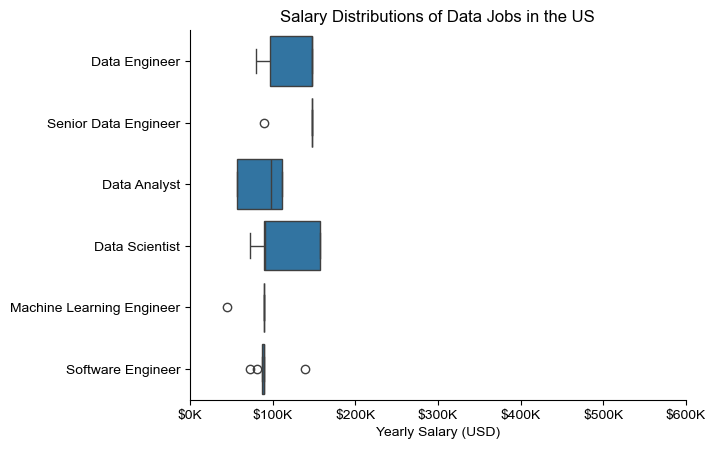

In [4]:
sns.boxplot(data=df_CZSK_top6, x='salary_year_avg', y='job_title_short', order=job_order)
sns.set_theme(style='ticks')
sns.despine()

# this is all the same
plt.title('Salary Distributions of Data Jobs in the US')
plt.xlabel('Yearly Salary (USD)')
plt.ylabel('')
plt.xlim(0, 600000) 
ticks_x = plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K')
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.show()

In [7]:
# Only get data analyst jobs in the CZSK
df_DA_CZ = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'Czechia')].copy()
df_DA_SK = df[(df['job_title_short']=='Data Analyst')&(df['job_country']=='Slovakia')].copy()
df_DA_CZSK = pd.concat([df_DA_CZ, df_DA_SK], ignore_index=True)

# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_DA_CZSK = df_DA_CZSK.dropna(subset=['salary_year_avg'])

df_DA_CZSK = df_DA_CZSK.explode('job_skills')

df_DA_CZSK[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
297,111175.0,sql
297,111175.0,python
297,111175.0,r
297,111175.0,snowflake
297,111175.0,redshift


In [9]:
df_DA_top_pay = df_DA_CZSK.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='median', ascending=False)

df_DA_top_pay = df_DA_top_pay.head(10)

df_DA_top_pay

,count,median
job_skills,,
azure,1,111175.0
bigquery,2,111175.0
go,1,111175.0
redshift,1,111175.0
looker,1,111175.0
python,3,111175.0
r,1,111175.0
sql,3,111175.0
snowflake,2,111175.0


In [10]:
df_DA_skills = df_DA_CZSK.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DA_skills = df_DA_skills.head(10).sort_values(by='median', ascending=False)

df_DA_skills

,count,median
job_skills,,
python,3,111175.0
sql,3,111175.0
bigquery,2,111175.0
snowflake,2,111175.0
azure,1,111175.0
go,1,111175.0
looker,1,111175.0
r,1,111175.0
redshift,1,111175.0


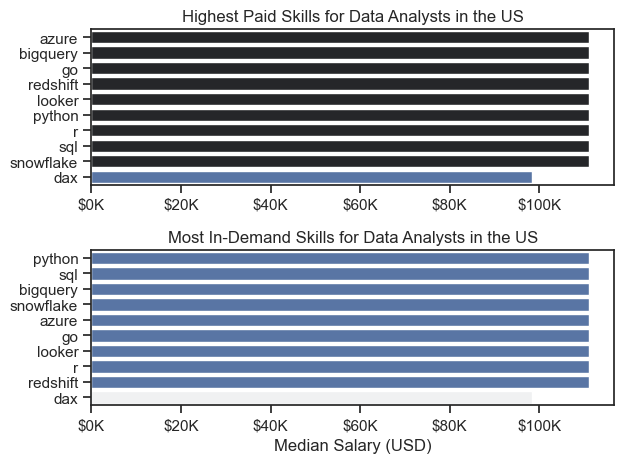

In [11]:
fig, ax = plt.subplots(2, 1)  

# Top 10 Highest Paid Skills for Data Analysts
sns.barplot(data=df_DA_top_pay, x='median', y=df_DA_top_pay.index, hue='median', ax=ax[0], palette='dark:b_r')
ax[0].legend().remove()
# original code:
# df_DA_top_pay[::-1].plot(kind='barh', y='median', ax=ax[0], legend=False) 
ax[0].set_title('Highest Paid Skills for Data Analysts in the US')
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))


# Top 10 Most In-Demand Skills for Data Analysts')
sns.barplot(data=df_DA_skills, x='median', y=df_DA_skills.index, hue='median', ax=ax[1], palette='light:b')
ax[1].legend().remove()
# original code:
# df_DA_skills[::-1].plot(kind='barh', y='median', ax=ax[1], legend=False)
ax[1].set_title('Most In-Demand Skills for Data Analysts in the US')
ax[1].set_ylabel('')
ax[1].set_xlabel('Median Salary (USD)')
ax[1].set_xlim(ax[0].get_xlim())  # Set the same x-axis limits as the first plot
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))

sns.set_theme(style='ticks')
plt.tight_layout()
plt.show()